In [165]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [210]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import OneClassSVM
from statsmodels.graphics.tsaplots import plot_acf

In [230]:
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')

In [231]:
train_data.head(5)

,DATETIME,SERVER,CPU,CPULOAD
0,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-0,3.88
1,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-1,11.33
2,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-10,5.31
3,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-11,5.25
4,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-12,0.28


In [232]:
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'], utc=True)
train_data['DATETIME'] = train_data['DATETIME'].dt.tz_localize(None)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312696 entries, 0 to 312695
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   DATETIME  312696 non-null  datetime64[ns]
 1   SERVER    312696 non-null  object        
 2   CPU       312696 non-null  object        
 3   CPULOAD   312696 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 9.5+ MB


In [233]:
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'], utc=True)
train_data['Month'] = train_data['DATETIME'].dt.month
train_data['Day'] = train_data['DATETIME'].dt.day
train_data['Hour'] = train_data['DATETIME'].dt.hour
train_data['Minute'] = train_data['DATETIME'].dt.minute
# train_data = train_data.drop(columns = ['DATETIME'])

In [234]:
train_data

,DATETIME,SERVER,CPU,CPULOAD,Month,Day,Hour,Minute
0,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-0,3.88,3,23,21,0
1,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-1,11.33,3,23,21,0
2,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-10,5.31,3,23,21,0
3,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-11,5.25,3,23,21,0
4,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-12,0.28,3,23,21,0
...,...,...,...,...,...,...,...,...
312691,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-5,16.17,5,30,20,45
312692,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-6,16.02,5,30,20,45
312693,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-7,14.14,5,30,20,45
312694,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-8,15.42,5,30,20,45


In [216]:
data = train_data[239688:]
data

,DATETIME,SERVER,CPU,CPULOAD,Month,Day,Hour,Minute
239688,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-0,6.47,5,15,0,0
239689,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-1,12.53,5,15,0,0
239690,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-10,3.52,5,15,0,0
239691,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-11,11.98,5,15,0,0
239692,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-12,0.58,5,15,0,0
...,...,...,...,...,...,...,...,...
312691,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-5,16.17,5,30,20,45
312692,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-6,16.02,5,30,20,45
312693,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-7,14.14,5,30,20,45
312694,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-8,15.42,5,30,20,45


# Outlier Detection Last

In [217]:
df_hourly = (data
             .join(data[239688:].groupby(['Hour','Day'])['CPULOAD'].mean(),
                   on = ['Hour', 'Day'], rsuffix='_Average')
            )
df_hourly

,DATETIME,SERVER,CPU,CPULOAD,Month,Day,Hour,Minute,CPULOAD_Average
239688,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-0,6.47,5,15,0,0,NaN
239689,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-1,12.53,5,15,0,0,NaN
239690,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-10,3.52,5,15,0,0,NaN
239691,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-11,11.98,5,15,0,0,NaN
239692,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-12,0.58,5,15,0,0,NaN
...,...,...,...,...,...,...,...,...,...
312691,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-5,16.17,5,30,20,45,NaN
312692,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-6,16.02,5,30,20,45,NaN
312693,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-7,14.14,5,30,20,45,NaN
312694,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-8,15.42,5,30,20,45,NaN


In [218]:
# Hourly
model_data = df_hourly[['CPULOAD', 'Hour', 'Day', 'Month', 'Minute', 'DATETIME']].set_index('DATETIME').dropna()
model_data

,CPULOAD,Hour,Day,Month,Minute
DATETIME,,,,,
2020-05-15 00:00:00+00:00,6.47,0,15,5,0
2020-05-15 00:00:00+00:00,12.53,0,15,5,0
2020-05-15 00:00:00+00:00,3.52,0,15,5,0
2020-05-15 00:00:00+00:00,11.98,0,15,5,0
2020-05-15 00:00:00+00:00,0.58,0,15,5,0
...,...,...,...,...,...
2020-05-30 20:45:00+00:00,16.17,20,30,5,45
2020-05-30 20:45:00+00:00,16.02,20,30,5,45
2020-05-30 20:45:00+00:00,14.14,20,30,5,45


In [219]:
from sklearn.ensemble import IsolationForest
def run_isolation_forest(model_data: pd.DataFrame, contamination=0.005, n_estimators=200, max_samples=0.7) -> pd.DataFrame:

    IF = (IsolationForest(random_state=0,
                          contamination=contamination,
                          n_estimators=n_estimators,
                          max_samples=max_samples)
         )

    IF.fit(model_data)

    output = pd.Series(IF.predict(model_data)).apply(lambda x: 1 if x == -1 else 0)

    score = IF.decision_function(model_data)

    return output, score

In [ ]:
outliers, score = run_isolation_forest(model_data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
df_hourly = (df_hourly
             .assign(Outliers = outliers)
             .assign(Score = score)
            )

df_hourly

,DATETIME,SERVER,CPU,CPULOAD,Month,Day,Hour,Minute,CPULOAD_Average,Outliers,Score
239688,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-0,6.47,5,15,0,0,NaN,NaN,0.003222
239689,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-1,12.53,5,15,0,0,NaN,NaN,0.014392
239690,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-10,3.52,5,15,0,0,NaN,NaN,0.019379
239691,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-11,11.98,5,15,0,0,NaN,NaN,0.010278
239692,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-12,0.58,5,15,0,0,NaN,NaN,0.042815
...,...,...,...,...,...,...,...,...,...,...,...
312691,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-5,16.17,5,30,20,45,NaN,NaN,0.034243
312692,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-6,16.02,5,30,20,45,NaN,NaN,0.035018
312693,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-7,14.14,5,30,20,45,NaN,NaN,0.031122
312694,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-8,15.42,5,30,20,45,NaN,NaN,0.036471


In [ ]:
IF = IsolationForest(random_state=0, contamination=0.005, n_estimators=200, max_samples=0.7)
IF.fit(model_data)

# New Outliers Column
df_hourly['Outliers'] = pd.Series(IF.predict(model_data)).apply(lambda x: 1 if x == -1 else 0)

# Get Anomaly Score
score = IF.decision_function(model_data)

# New Anomaly Score column
df_hourly['Score'] = score

df_hourly.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,DATETIME,SERVER,CPU,CPULOAD,Month,Day,Hour,Minute,CPULOAD_Average,Outliers,Score
239688,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-0,6.47,5,15,0,0,NaN,NaN,0.003222
239689,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-1,12.53,5,15,0,0,NaN,NaN,0.014392
239690,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-10,3.52,5,15,0,0,NaN,NaN,0.019379
239691,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-11,11.98,5,15,0,0,NaN,NaN,0.010278
239692,2020-05-15 00:00:00+00:00,CIHAZ_301,CPU-12,0.58,5,15,0,0,NaN,NaN,0.042815


In [ ]:
len(df_hourly.query("Outliers == 1"))

0

# Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# **Outlier** **Detection**

In [ ]:
train_data_cpuload = train_data['CPULOAD']

<Axes: xlabel='CPULOAD'>

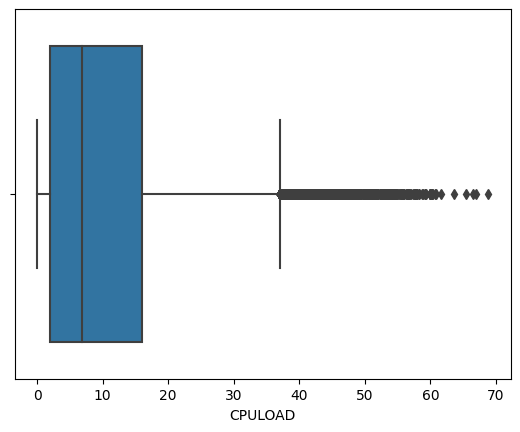

In [ ]:
sns.boxplot(x = train_data_cpuload)

In [ ]:
Q1 = train_data_cpuload.quantile(0.25)
Q3 = train_data_cpuload.quantile(0.75)
IQR = Q3 - Q1
IQR

13.989999999999998

In [ ]:
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

In [ ]:
lower_bound

-18.935

In [ ]:
upper_bound

37.025

In [ ]:
outlier_indexes = train_data_cpuload[(train_data_cpuload < lower_bound) | (train_data_cpuload > upper_bound)].index
outlier_indexes

Int64Index([  2047,   2234,   2445,   2684,   2714,   2715,   2735,   2830,
              3242,   3243,
            ...
            307152, 307222, 307223, 308313, 309694, 311087, 311108, 311110,
            311111, 312460],
           dtype='int64', length=2667)

# Visualization

In [235]:
train_data_group = train_data.groupby('CPU').mean()
train_data_group.index.values

<ipython-input-235-3d96f6b21da1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_data_group = train_data.groupby('CPU').mean()


array(['CPU-0', 'CPU-1', 'CPU-10', 'CPU-11', 'CPU-12', 'CPU-13', 'CPU-14',
       'CPU-15', 'CPU-16', 'CPU-17', 'CPU-18', 'CPU-19', 'CPU-2',
       'CPU-20', 'CPU-21', 'CPU-22', 'CPU-23', 'CPU-3', 'CPU-4', 'CPU-5',
       'CPU-6', 'CPU-7', 'CPU-8', 'CPU-9'], dtype=object)

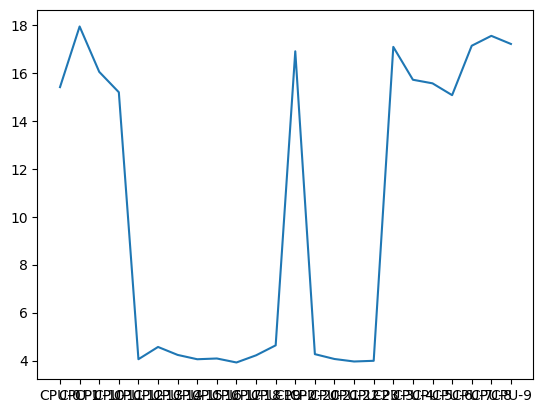

In [236]:
plt.plot(train_data_group.index.values, train_data_group['CPULOAD'])

In [237]:
train_data

,DATETIME,SERVER,CPU,CPULOAD,Month,Day,Hour,Minute
0,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-0,3.88,3,23,21,0
1,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-1,11.33,3,23,21,0
2,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-10,5.31,3,23,21,0
3,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-11,5.25,3,23,21,0
4,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-12,0.28,3,23,21,0
...,...,...,...,...,...,...,...,...
312691,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-5,16.17,5,30,20,45
312692,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-6,16.02,5,30,20,45
312693,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-7,14.14,5,30,20,45
312694,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-8,15.42,5,30,20,45


# Anomaly Detection

In [ ]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN()
data = train_data.drop(columns = ['CPULOAD'])
dbscan.fit(data)

TypeError: ignored

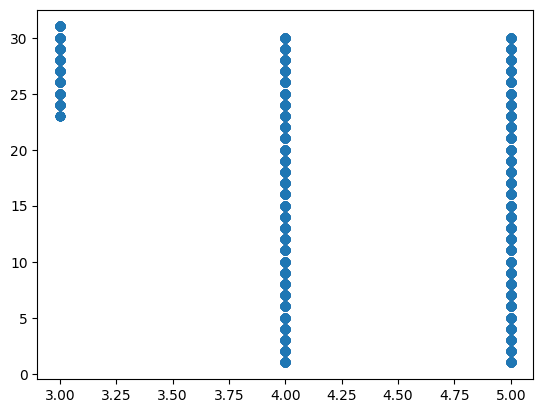

In [ ]:
colors = model.labels_
plt.scatter(data["Month"], data["Day"])

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data)
distances, indices = nbrs.kneighbors(data)

In [ ]:
distances.shape

(6524, 2)

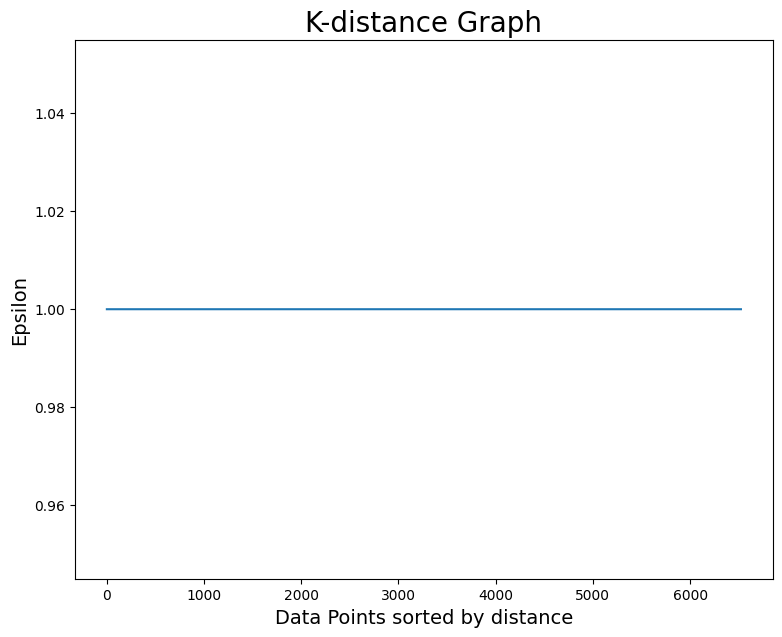

In [ ]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(9,7))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [ ]:
# input data
data = train_data[['Day', 'CPULOAD']]# specify & fit model
model = DBSCAN(eps = 0.4, min_samples = 10).fit(data)

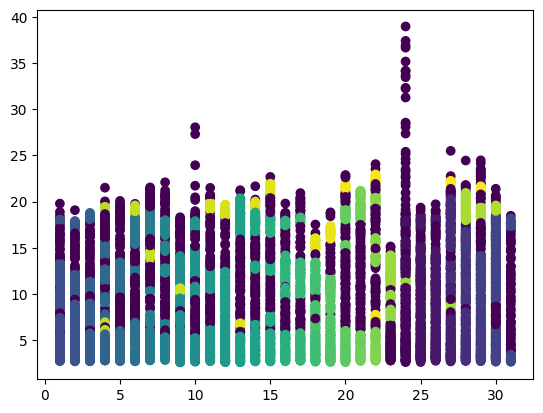

In [ ]:
# visualize outputs
colors = model.labels_
plt.scatter(train_data["Day"], train_data["CPULOAD"], c = colors)

# Linear Regression

In [238]:
train_data

,DATETIME,SERVER,CPU,CPULOAD,Month,Day,Hour,Minute
0,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-0,3.88,3,23,21,0
1,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-1,11.33,3,23,21,0
2,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-10,5.31,3,23,21,0
3,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-11,5.25,3,23,21,0
4,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-12,0.28,3,23,21,0
...,...,...,...,...,...,...,...,...
312691,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-5,16.17,5,30,20,45
312692,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-6,16.02,5,30,20,45
312693,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-7,14.14,5,30,20,45
312694,2020-05-30 20:45:00+00:00,CIHAZ_305,CPU-8,15.42,5,30,20,45


In [239]:
train_data = train_data.drop(columns = ['DATETIME'])
train_data

,SERVER,CPU,CPULOAD,Month,Day,Hour,Minute
0,CIHAZ_301,CPU-0,3.88,3,23,21,0
1,CIHAZ_301,CPU-1,11.33,3,23,21,0
2,CIHAZ_301,CPU-10,5.31,3,23,21,0
3,CIHAZ_301,CPU-11,5.25,3,23,21,0
4,CIHAZ_301,CPU-12,0.28,3,23,21,0
...,...,...,...,...,...,...,...
312691,CIHAZ_305,CPU-5,16.17,5,30,20,45
312692,CIHAZ_305,CPU-6,16.02,5,30,20,45
312693,CIHAZ_305,CPU-7,14.14,5,30,20,45
312694,CIHAZ_305,CPU-8,15.42,5,30,20,45


In [240]:
train_data = train_data.drop(columns = ['CPU'])

In [241]:
train_data = pd.get_dummies(data = train_data, columns = ['SERVER'])

In [242]:
train_data

,CPULOAD,Month,Day,Hour,Minute,SERVER_CIHAZ_301,SERVER_CIHAZ_305
0,3.88,3,23,21,0,1,0
1,11.33,3,23,21,0,1,0
2,5.31,3,23,21,0,1,0
3,5.25,3,23,21,0,1,0
4,0.28,3,23,21,0,1,0
...,...,...,...,...,...,...,...
312691,16.17,5,30,20,45,0,1
312692,16.02,5,30,20,45,0,1
312693,14.14,5,30,20,45,0,1
312694,15.42,5,30,20,45,0,1


In [178]:
# train_data = train_data.drop(columns = ['CPU'])

In [243]:
y = train_data['CPULOAD'] # label
X = train_data.drop(columns = ['CPULOAD']) # data

In [244]:
y.head(5)

0     3.88
1    11.33
2     5.31
3     5.25
4     0.28
Name: CPULOAD, dtype: float64

In [245]:
X.head(5)

,Month,Day,Hour,Minute,SERVER_CIHAZ_301,SERVER_CIHAZ_305
0,3,23,21,0,1,0
1,3,23,21,0,1,0
2,3,23,21,0,1,0
3,3,23,21,0,1,0
4,3,23,21,0,1,0


In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [247]:
X_train

,Month,Day,Hour,Minute,SERVER_CIHAZ_301,SERVER_CIHAZ_305
17448,3,27,16,0,1,0
150722,4,25,16,15,1,0
149790,4,25,11,15,0,1
50085,4,3,19,0,0,1
188303,5,3,20,15,1,0
...,...,...,...,...,...,...
119879,4,18,23,15,1,0
259178,5,19,5,45,0,1
131932,4,21,14,0,0,1
146867,4,24,20,0,1,0


In [248]:
y_train

17448     21.41
150722     5.00
149790     5.98
50085     16.34
188303    14.08
          ...  
119879     5.73
259178    13.69
131932    15.69
146867     0.65
121958     5.77
Name: CPULOAD, Length: 209506, dtype: float64

In [249]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [250]:
coefficients = pd.DataFrame({'Variable': X_train.columns, 'Coefficient': regressor.coef_})
print(coefficients)

           Variable  Coefficient
0             Month     0.919150
1               Day     0.058951
2              Hour     0.151196
3            Minute    -0.001424
4  SERVER_CIHAZ_301    -2.909862
5  SERVER_CIHAZ_305     2.909862


In [251]:
y_pred = regressor.predict(X_test)
y_pred

array([11.87592764, 13.11979665, 13.26002734, ..., 14.14487402,
        7.80063619, 13.47249512])

In [252]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE): ", mse)
print("R-squared Score: ", r2)

Mean Squared Error (MSE):  87.99146914067784
R-squared Score:  0.10558476762718383


# Anomaly Detection

In [ ]:
from sklearn import preprocessing

X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)

KMeans(n_clusters=2, n_init='auto', random_state=0)

<Axes: xlabel='Month', ylabel='Day'>

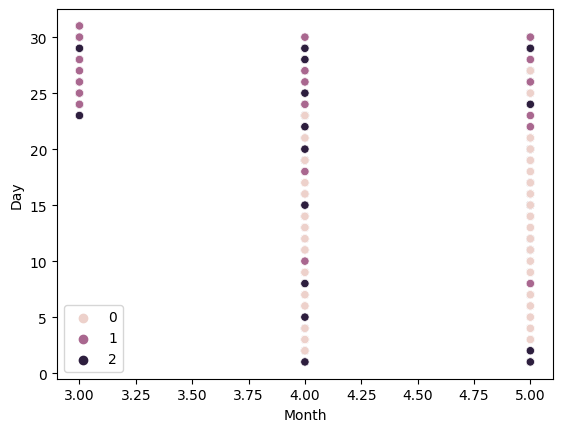

In [ ]:
sns.scatterplot(data = X_train, x = 'Month', y = 'Day', hue = kmeans.labels_)

In [ ]:
sns.boxplot(x = kmeans.labels_, y = y_train)

In [ ]:
train_data['CPULOAD'].plot()

In [ ]:
print(score)

[0.47999759005510645, 0.36818033721494675, 0.3361876622304635, 0.362968077716889, 0.3505541238218591, 0.3712091953706432]


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)

KMeans(n_clusters=2, n_init='auto', random_state=0)

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean')

0.47999759005510645

# Test

In [253]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103190 entries, 39378 to 59525
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Month             103190 non-null  int64
 1   Day               103190 non-null  int64
 2   Hour              103190 non-null  int64
 3   Minute            103190 non-null  int64
 4   SERVER_CIHAZ_301  103190 non-null  uint8
 5   SERVER_CIHAZ_305  103190 non-null  uint8
dtypes: int64(4), uint8(2)
memory usage: 4.1 MB


In [254]:
y_test

39378     30.75
227722    16.32
286755     8.55
24662      1.46
196790     1.13
          ...  
45556      2.81
124487     3.94
238080    36.61
95907      8.58
59525      3.19
Name: CPULOAD, Length: 103190, dtype: float64

In [ ]:
import statsmodels.api as sm

In [ ]:
lm = sm.OLS(y_train, X_train)

In [ ]:
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CPULOAD   R-squared (uncentered):                   0.780
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              3874.
Date:                Thu, 13 Jul 2023   Prob (F-statistic):                        0.00
Time:                        07:02:39   Log-Likelihood:                         -13578.
No. Observations:                4363   AIC:                                  2.716e+04
Df Residuals:                    4359   BIC:                                  2.719e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Month          1.5645      0.048     32.333      0.000       1.470       1.659
Day            0.0768      0.008      9.328      0.000       0.061       0.093
Hour           0.1758      0.012     15.186      0.000       0.153       0.198
Minute         0.0017      0.005      0.351      0.725      -0.008       0.011
==============================================================================
Omnibus:                      746.865   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.101
Skew:                           0.410   Prob(JB):                     3.02e-60
Kurtosis:                       2.087   Cond. No.                         20.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [266]:
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

In [267]:
test_data

,index,DATETIME,SERVER
0,0,2020-05-31 00:00:00+03:00,CIHAZ_301
1,1,2020-05-31 00:00:00+03:00,CIHAZ_305
2,2,2020-05-31 00:15:00+03:00,CIHAZ_301
3,3,2020-05-31 00:15:00+03:00,CIHAZ_305
4,4,2020-05-31 00:30:00+03:00,CIHAZ_301
...,...,...,...
187,187,2020-05-31 23:15:00+03:00,CIHAZ_305
188,188,2020-05-31 23:30:00+03:00,CIHAZ_301
189,189,2020-05-31 23:30:00+03:00,CIHAZ_305
190,190,2020-05-31 23:45:00+03:00,CIHAZ_301


In [257]:
train_data

,CPULOAD,Month,Day,Hour,Minute,SERVER_CIHAZ_301,SERVER_CIHAZ_305
0,3.88,3,23,21,0,1,0
1,11.33,3,23,21,0,1,0
2,5.31,3,23,21,0,1,0
3,5.25,3,23,21,0,1,0
4,0.28,3,23,21,0,1,0
...,...,...,...,...,...,...,...
312691,16.17,5,30,20,45,0,1
312692,16.02,5,30,20,45,0,1
312693,14.14,5,30,20,45,0,1
312694,15.42,5,30,20,45,0,1


In [269]:
test_data = pd.get_dummies(data = test_data, columns = ['SERVER'])

In [268]:
test_data['DATETIME'] = pd.to_datetime(test_data['DATETIME'], utc=True)
test_data['Month'] = test_data['DATETIME'].dt.month
test_data['Day'] = test_data['DATETIME'].dt.day
test_data['Hour'] = test_data['DATETIME'].dt.hour
test_data['Minute'] = test_data['DATETIME'].dt.minute
test_data = test_data.drop(columns = ['DATETIME'])

In [194]:
# test_data = test_data.drop(columns = ['SERVER'])

In [270]:
# test_data = test_data.rename(columns={'DATETIME': 'ds'})
test_data

,index,Month,Day,Hour,Minute,SERVER_CIHAZ_301,SERVER_CIHAZ_305
0,0,5,30,21,0,1,0
1,1,5,30,21,0,0,1
2,2,5,30,21,15,1,0
3,3,5,30,21,15,0,1
4,4,5,30,21,30,1,0
...,...,...,...,...,...,...,...
187,187,5,31,20,15,0,1
188,188,5,31,20,30,1,0
189,189,5,31,20,30,0,1
190,190,5,31,20,45,1,0


In [271]:
test_data = test_data.drop(columns = ['index'])
test_data

,Month,Day,Hour,Minute,SERVER_CIHAZ_301,SERVER_CIHAZ_305
0,5,30,21,0,1,0
1,5,30,21,0,0,1
2,5,30,21,15,1,0
3,5,30,21,15,0,1
4,5,30,21,30,1,0
...,...,...,...,...,...,...
187,5,31,20,15,0,1
188,5,31,20,30,1,0
189,5,31,20,30,0,1
190,5,31,20,45,1,0


In [272]:
y_pred = regressor.predict(test_data)
y_pred

array([10.21825684, 16.03798086, 10.19690206, 16.01662608, 10.17554728,
       15.9952713 , 10.1541925 , 15.97391652, 10.36945259, 16.18917661,
       10.34809781, 16.16782183, 10.32674303, 16.14646706, 10.30538825,
       16.12511228, 10.52064834, 16.34037237, 10.49929357, 16.31901759,
       10.47793879, 16.29766281, 10.45658401, 16.27630803,  7.10209742,
       12.92182144,  7.08074264, 12.90046666,  7.05938786, 12.87911189,
        7.03803308, 12.85775711,  7.25329317, 13.0730172 ,  7.2319384 ,
       13.05166242,  7.21058362, 13.03030764,  7.18922884, 13.00895286,
        7.40448893, 13.22421295,  7.38313415, 13.20285817,  7.36177937,
       13.18150339,  7.34042459, 13.16014862,  7.55568468, 13.3754087 ,
        7.5343299 , 13.35405393,  7.51297513, 13.33269915,  7.49162035,
       13.31134437,  7.70688044, 13.52660446,  7.68552566, 13.50524968,
        7.66417088, 13.4838949 ,  7.6428161 , 13.46254012,  7.85807619,
       13.67780021,  7.83672141, 13.65644543,  7.81536663, 13.63

In [273]:
pd.DataFrame(y_pred).to_csv('submission.csv')

In [ ]:
!zip -r '/content/submission.csv' '/content/submission'

	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (/content/submission.csv)
